# Logistic regression and feed forward NN

Today, you will be tinkering with a pure-python feed forward neural network.
- Part 1.1: Tinker with a visualization of neural network classification
- Part 1.2: Train a pure-Python neural network

In [2]:
%matplotlib inline

import numpy as np
import random
import matplotlib.pylab as plt
from scipy.interpolate import interp1d

## Exercises

### Part 1.1: Tinker with some visuals

Before we dive in to the code, it's really important that our intuition about what neural networks are doing is as good as possible. And the best, most fun, way to do that is to play around and with things a bit, so go familiarize yourself with the [Tensorflow Playground](https://playground.tensorflow.org/), slide some knobs and pull some levers.

> **Ex. 1.1.1** Using [the dataset](https://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=gauss&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.42272&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) with the two well-seperated guassian distributions, create the minimal neural network that seperates the clusters. You can report your answer with a link (the URL on playground.tensorflow.org changes as you update the network, so at any time you can use the link to show others what you have created).

> **Ex. 1.1.2** Using [the dataset](https://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.16631&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) with the hard-to-seperate circles, create the minimal neural network that seperates the clusters. Again, report your answer with a link.

> **Ex. 1.1.3** See if you can create a network that performs well on the [the dataset](https://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=spiral&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.08961&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) with the intertwined spirals. If possible, include in your answer not only the link but also a screenshot of the scatter plot.

### Part 1.2: A pure-Python neural network

Now, let's inspect Michael Nielsen's neural network. He ends the first chapter of his book by implementing all the stuff he went through, and below I've synthesized this code into a single working example, with some minor readibility edits and updates so it works in Python 3. Here and there, I've inserted some questions in code comments for you to address.

In [3]:
# Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z) * (1 - sigmoid(z))

def step(z, threshold=0.5):
    if z > threshold:
        return 1
    return 0

# Feed forward neural network class
class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        
        self.num_layers = len(sizes)
        self.sizes = sizes
        
        # Q1: Print these out for a network of size `[2, 3, 1]`, and explain their structure and contents
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        
        # Q2: What is `a`? How many iterations will this loop run? For a `sizes=[2, 3, 1]`
        # network, what is the shape of `a` at each iteration?
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a
    
    
    # --------------------------------------------------------------------------- #
    # Don't think too hard about the code below. We will look into that next week #
    # --------------------------------------------------------------------------- #
    
    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None, silent=False):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        
        n = len(training_data)
        if test_data:
            n_test = len(test_data)
        
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)
            ]
            
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            
            if not silent:
                if test_data:
                    print("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test))
                else:
                    print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        self.weights = [
            w - eta / len(mini_batch) * nw
            for w, nw in zip(self.weights, nabla_w)
        ]
        self.biases = [
            b - eta / len(mini_batch) * nb
            for b, nb in zip(self.biases, nabla_b)
        ]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book. Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on. It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return nabla_b, nabla_w

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        if self.sizes[-1] == 1:
            test_results = [
                (step(self.feedforward(x)), y)
                for x, y in test_data
            ]
        else:
            test_results = [
                (np.argmax(self.feedforward(x)), y)
                for x, y in test_data
            ]
        return sum(int(y_pred == y) for (y_pred, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return output_activations - y

> **Ex. 1.2.1** Inspect the code and gain an understanding of what happens in the `__init__` and `feedforward` methods.
For now, we will not worry about what the rest of the class methods do (subject of next week).
To structure your analysis, there are two questions in code comments. Go ahead and give your answers in plain text (and code when necessary) below.
>
> *Hint: You need to closely follow the code. You can verify your understanding by inspecting variables. Simply create an instance of the network and you will be able to access the variables of that instance. Example:*
>
>     net = Network([2, 3, 1])
>     net.biases  # this gets you the biases property of the network

#### Classifying data

Now let's use this network to classify some points. Remember the examples from the lecture with the two clusters? Below is some code for generating data like that.

In [4]:
def generate_X_linear(N=200):
    X = np.vstack([
        np.random.normal([-2, -2], 1, size=(int(N/2), 2)),
        np.random.normal([2, 2], 1, size=(int(N/2), 2))
    ])

    y = np.array([0] * int(N/2) + [1] * int(N/2)).reshape(-1, 1)
    
    return X, y

def generate_X_nonlinear(N=200, R=5):
    X_inner = np.random.normal([0, 0], 1, size=(int(N/2), 2))

    X_outer = np.array([
        [R*np.cos(theta), R*np.sin(theta)]
        for theta in np.linspace(0, 2 * np.pi, int(N/2))
    ]) + np.random.randn(int(N/2), 2)

    X = np.vstack([X_inner, X_outer])
    y = np.array([0] * int(N/2) + [1] * int(N/2)).reshape(-1, 1)
    
    return X, y

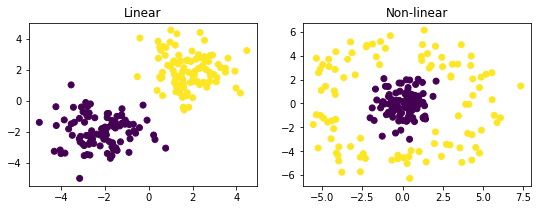

In [5]:
plt.figure(figsize=(9, 3))

X, y = generate_X_linear()
plt.subplot(1, 2, 1)
plt.title("Linear", fontsize=12)
plt.scatter(X[:, 0], X[:, 1], c=list(y.reshape(-1)))

X, y = generate_X_nonlinear()
plt.subplot(1, 2, 2)
plt.title("Non-linear", fontsize=12)
plt.scatter(X[:, 0], X[:, 1], c=list(y.reshape(-1)))

plt.show()

In [7]:
X.shape

(200, 2)

In [8]:
y.shape

(200, 1)

`X` and `y` are numpy arrays of shape *(200,2)* and *(200,1)* respectively. The data needs to be formatted a little different when we give it to Nielsen's code. Basically, it asks for (x, y) *tuple pairs*, so in each tuple you have a datapoint and its label. Furthermore, both x and y must be vertical vectors **(see Ex. 1.2.1)**.

The function below takes `X` and `y` and returns the data in this format:

In [6]:
def prepare_data(X, y):
    """Format the dataset X and y so it fits with Nielsen's code."""
    return [
        (X[i].reshape(-1, 1), y[i].reshape(-1, 1))  # our tuple (x, y)
        for i in range(len(y))
    ]

> **Ex. 1.2.2**: Create a neural network with `sizes=[2, 1]`. This is actually just the basic Perceptron with two inputs and a single output (or a logistic regression with two variables). Generate 1e5 training datapoints and 1e4 testing datapoints using the `generate_X_linear` function, and *fit the neural network* to this data. Once you've fitted the network, predict the classes of your test data and make three scatterplots of your testdata:
> - One where you color each point according to the output of the neural network
> - Same as above, but binarizing the prediction using a threshold of 0.5 (`prediction > 0.5`)
> - One colouring the testdata according to its *true* class
> Can you say something about the points that are being mislabeled?
>
>*Hint: You'll probably find some of Nielsen's examples from [Chapter 1](http://neuralnetworksanddeeplearning.com/chap1.html) in his book useful. Also, note that predictions are floating point numbers between 0 and 1, not hard 0s and 1s, due to the sigmoid activation function.*

> **Ex. 1.2.3**: Now create a different network, which is able to successfully classify the data generated with the `generate_X_nonlinear` function. Comment on the result!
>
>*Hint: Think back to the slides to figure out what `sizes` (number of neurons in each layer) should be.*